In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
import geopandas as gpd
import seaborn as sns

In [2]:
df = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')

In [3]:
def treat_data(df):
    """Clean and treat data.
    """
    
    # Get only the necessary columns for the graph.
    df = df[["location", "date", "people_fully_vaccinated_per_hundred"]].copy()

    # Converts date column from string to datetime type.
    df.loc[:,"date"] = pd.to_datetime(df["date"])

    df = pd.pivot_table(df, values="people_fully_vaccinated_per_hundred", columns="location", index="date")

    # Drop countries whose data is too sparse for any interpolation technique.
    missing = df.isnull().mean()[df.isnull().mean() >= 0.96].index.values
    df = df.drop(missing, axis=1)
    
    # Interpolate missing values with a straight line.
    df = df.interpolate(method="linear")
    
    return df

In [4]:
def label_country(df, country, display=None, color="gray"):
    """Display the name of a country next to its curve.
    """
    number = df[country].max()
    if display == None:        
        label = f"{country} {int(number)}%"
    else: 
        label = f"{display} {int(number)}%"
    plt.text(df.index[-1], df[country][-1], label, fontsize=14, color=color)   

In [30]:
def plot_curves(df, n, title, subtitle, filename):
    # I want the graph to have big fonts and an opaque white background,
    # otherwise the resulting PNG image will look funny in some contexts.
    plt.rcParams.update({'font.size': 14})
    plt.rcParams['figure.facecolor'] = 'white'

    fig, ax = plt.subplots(figsize=(12,8))

    # Plot all curves in gray and highlight the Brazilian one in steelblue.
    df.plot(ax=ax, alpha=0.15, color="gray")
    df.Brazil.plot(ax=ax, alpha=1, color="steelblue")

    # Pretty graphs don't need spines, they said.
    ax.spines["top"].set_visible(False)    
    ax.spines["bottom"].set_visible(False)    
    ax.spines["right"].set_visible(False)    
    ax.spines["left"].set_visible(False)

    # Nor axes.
    ax.get_yaxis().set_visible(False)

    # Nor legends.
    ax.get_legend().remove()

    # Nor ticks.
    plt.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False)

    # Not even labels.
    plt.xlabel("")

    # Print the top n countries names next to their respective curves,
    # plus Brazil in blue.
    countries_list = df.max().sort_values(ascending=False)
    for country in countries_list.head(n).index:
        label_country(df, country)
    label_country(df, "Brazil", color="steelblue")

    # Set header and footer.
    ax.set_title(title)
    plt.text(df.index[df.shape[0]//2], df.max().max(),
             s=subtitle, horizontalalignment='center')
    plt.text(df.index[0], -23,
             "Filtragem: países com mais de 1 milhão de habitantes\n"                           
             "Fonte: https://covid.ourworldindata.org/data/owid-covid-data.csv\n"
             "Autor: Bruno Arine\n"
             "Última atualização: {}\n".format(datetime.datetime.now().strftime("%Y-%m-%d")),
             fontsize=10)
    
    plt.tight_layout()
    plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
    plt.show()


In [6]:
# Latin America comprises all the countries in the South and North American continent
# except for Canada and United States.
latam = ((df.continent == "South America") | (df.continent == "North America")) & \
         ((df.location != "Canada") & (df.location != "United States")) & \
         (df.population > 1000000)

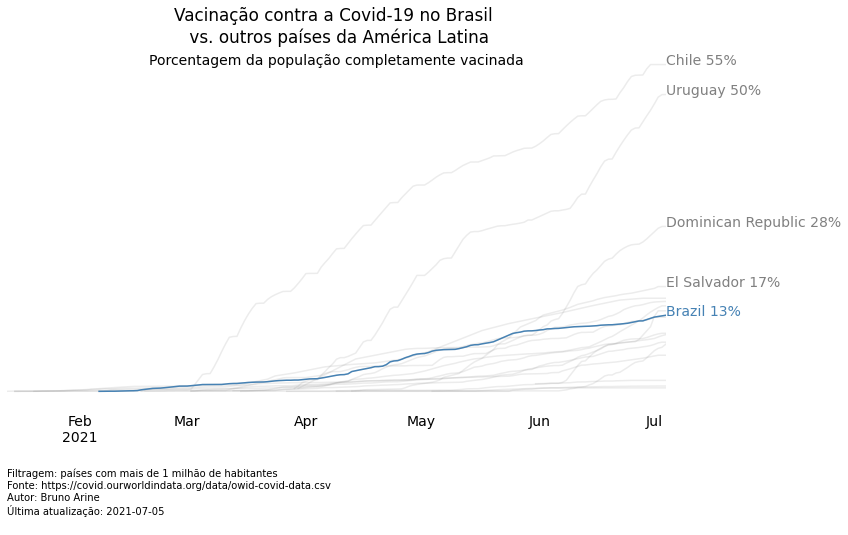

In [31]:
plot_curves(df=treat_data(df[latam]),
            n=4,
            title="Vacinação contra a Covid-19 no Brasil \n vs. outros países da América Latina",        
            subtitle="Porcentagem da população completamente vacinada",            
            filename="brazil-vs-latam.png")

But does it make sense to compare countries according to their geographical location? Not so much. Take a look at how crazy the differences are between Latin American countries when it comes to GDP per capita, for instance.

In [8]:
(df[latam]
    .groupby("location")["gdp_per_capita"]
    .max()
    .sort_values(ascending=False)
    .dropna())

location
Trinidad and Tobago    28763.071
Chile                  22767.037
Panama                 22267.037
Uruguay                20551.409
Argentina              18933.907
Mexico                 17336.469
Venezuela              16745.022
Costa Rica             15524.995
Dominican Republic     14600.861
Brazil                 14103.452
Colombia               13254.949
Peru                   12236.706
Ecuador                10581.936
Paraguay                8827.010
Jamaica                 8193.571
Guatemala               7423.808
El Salvador             7292.458
Bolivia                 6885.829
Nicaragua               5321.444
Honduras                4541.795
Haiti                   1653.173
Name: gdp_per_capita, dtype: float64

In [9]:
countries_gdp = df[df.population > 1e6] \
    .groupby("location")[["iso_code", "gdp_per_capita"]] \
    .max() \
    .sort_values(by="gdp_per_capita", ascending=False) \
    .dropna()

In [10]:
from sklearn.cluster import KMeans

X = np.array(countries_gdp["gdp_per_capita"]).reshape(-1,1)

sum_dist = []

K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=33634)
    km.fit(X)
    sum_dist.append(km.inertia_)

Text(0, 0.5, 'Dessimilaridade')

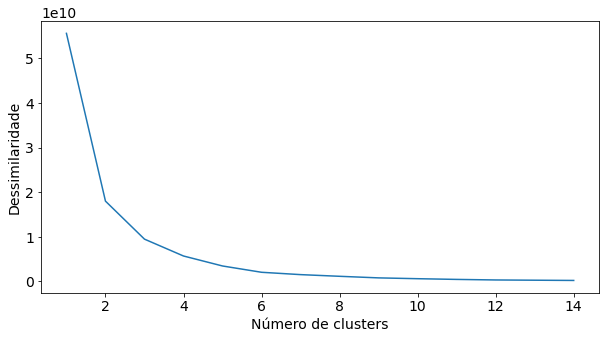

In [32]:
plt.figure(figsize=(10,5))
plt.plot(K, sum_dist)
plt.xlabel("Número de clusters")
plt.ylabel("Dessimilaridade")

In [12]:
km = KMeans(n_clusters=6, random_state=33634)

km.fit(X)

countries_gdp = pd.DataFrame(countries_gdp)
countries_gdp["group"] = km.predict(X)

In [13]:
countries_gdp

,iso_code,gdp_per_capita,group
location,,,
Qatar,QAT,116935.600,3
Singapore,SGP,85535.383,3
Ireland,IRL,67335.293,1
United Arab Emirates,ARE,67293.483,1
Kuwait,KWT,65530.537,1
...,...,...,...
Niger,NER,926.000,0
Democratic Republic of Congo,COD,808.133,0
Liberia,LBR,752.788,0


In [14]:
brazil_group = countries_gdp.loc["Brazil"].group
group = countries_gdp[countries_gdp.group == brazil_group].index.values

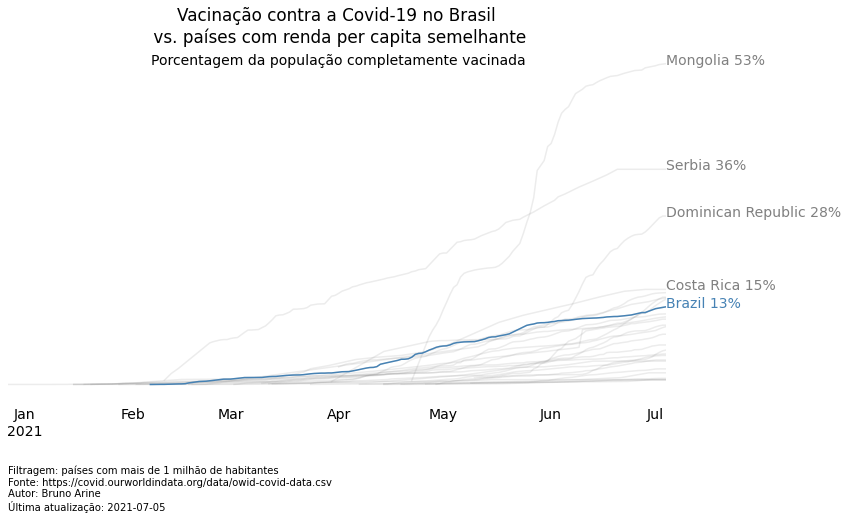

In [34]:
plot_curves(df=treat_data(df[df.location.isin(group)]),
            n=4,
            title="Vacinação contra a Covid-19 no Brasil\n vs. países com renda per capita semelhante",
            subtitle="Porcentagem da população completamente vacinada",
            filename="brazil-vs-world.png")

In [17]:
pd.DataFrame(df[df.location.isin(group)]
             .groupby("location")[["people_fully_vaccinated_per_hundred", "gdp_per_capita"]]
             .max()
             .sort_values(by="people_fully_vaccinated_per_hundred", ascending=False)
             .dropna())

,people_fully_vaccinated_per_hundred,gdp_per_capita
location,,
Mongolia,53.73,11840.846
Serbia,36.04,14048.881
Dominican Republic,28.20,14600.861
Costa Rica,15.92,15524.995
China,15.51,15308.712
Mexico,15.38,17336.469
Colombia,14.62,13254.949
Albania,14.48,11803.431
Azerbaijan,14.28,15847.419


/home/soldeace/.local/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(
/home/soldeace/.local/lib/python3.9/site-packages/geopandas/plotting.py:641: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


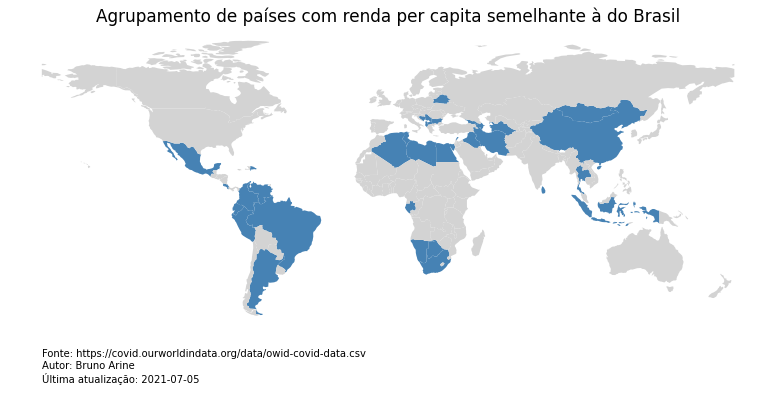

In [36]:
# Create a geopandas DataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

# Join world and countries_list by the ISO code
worldmap = pd.merge(world, countries_gdp, left_on="iso_a3", right_on="iso_code")

# Plot world map with different colors
fig, ax = plt.subplots(figsize=(11,8))
worldmap[worldmap.group==brazil_group].plot(column="group",
              ax=ax,
              color="steelblue", 
              legend=False)

worldmap[worldmap.group!=brazil_group].plot(column="group",
              ax=ax,
              color="lightgray", 
              legend=False)

ax.set_title("Agrupamento de países com renda per capita semelhante à do Brasil")
plt.text(-180,-95,            
             "Fonte: https://covid.ourworldindata.org/data/owid-covid-data.csv\n"
             "Autor: Bruno Arine\n"
             "Última atualização: {}\n".format(datetime.datetime.now().strftime("%Y-%m-%d")),
             fontsize=10)

ax.set_axis_off()
plt.tight_layout()

plt.savefig("worldmap.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()